# NLP with Disaster Tweets

This notebook aims to use Natural Language Processing to predict which tweets are about natural disasters and which aren't.  The challenge in it is that sometimes the wording someone might use could contain words and phrases that someone might use to describe a natural disaster but in reality it is something much less dangerous.  While it might be very clear to a person what is being described, it is less clear to a machine.  This notebook will primarily use RNNs to try to build an accurate model to predict the tweets.

In [1]:
#import libraries
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/tools/tokenization.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk  
nltk.download('stopwords') 
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import LSTM, Embedding, SimpleRNN, Reshape, GRU
from keras.initializers import Constant
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.regularizers import l1, l2
from keras.optimizers import Adam
from keras.layers import LeakyReLU
import tensorflow as tf
import tokenization
import tensorflow_hub as hub
import tensorflow_text as text
from transformers import TFAutoModel, BertTokenizer
import string
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

## Import the Data

This dataset comes from the kaggle competition Natural Language Processing with Disaster Tweets.  https://www.kaggle.com/competitions/nlp-getting-started/data  The data is a training set, a testing set, and a sample submission file in the correct format.  The training set contains id - a unique identifier for each tweet, text - the text of the tweet, location - the location the tweet was sent from (may be blank), keyword - a particular keyword from the tweet (may be blank), target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0).  The training set contains 7613 rows and the test set contains 3263 rows.

### 

In [73]:
# Load the data
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train.shape, test.shape

((7613, 5), (3263, 4))

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### EDA

First lets take a look at how many missing values are in location and keyword since it was mentioned on the kaggle data page that these may contain missing data.

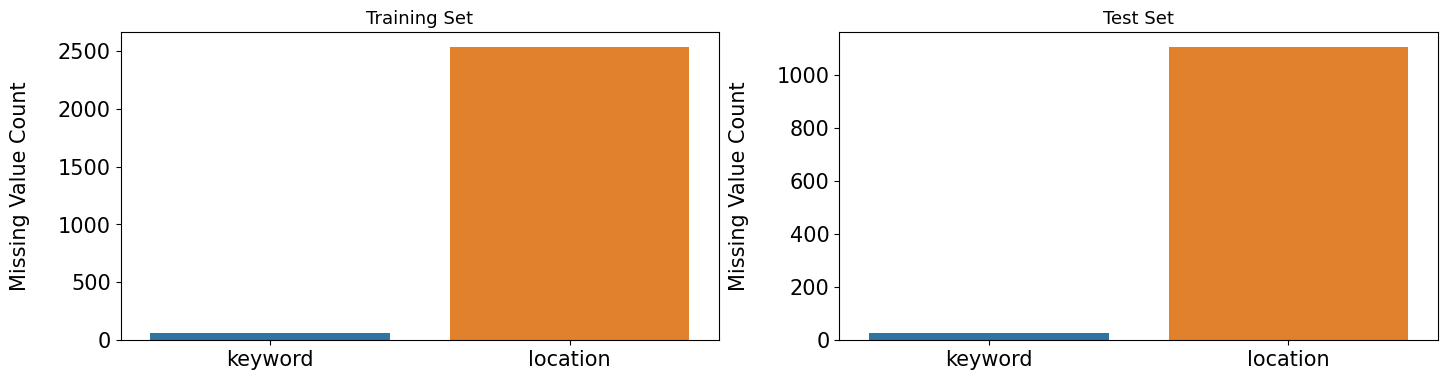

In [8]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

for i, df in enumerate([train, test]):
    sns.barplot(x=df[missing_cols].isnull().sum().index, y=df[missing_cols].isnull().sum().values, ax=axes[i])
    axes[i].set_ylabel('Missing Value Count', size=15, labelpad=20)
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)
    axes[i].set_title('Training Set' if i == 0 else 'Test Set', fontsize=13)



# Fill missing values with 'no_keyword' and 'no_location'
for df in [train, test]:
    df['keyword'] = df['keyword'].fillna('no_keyword')
    df['location'] = df['location'].fillna('no_location')

So they do contain a lot of missing data.

Now lets take a look at the distribution of the targets.

(array([   0., 1000., 2000., 3000., 4000., 5000.]),
 [Text(0, 0.0, '0'),
  Text(0, 1000.0, '1000'),
  Text(0, 2000.0, '2000'),
  Text(0, 3000.0, '3000'),
  Text(0, 4000.0, '4000'),
  Text(0, 5000.0, '5000')])

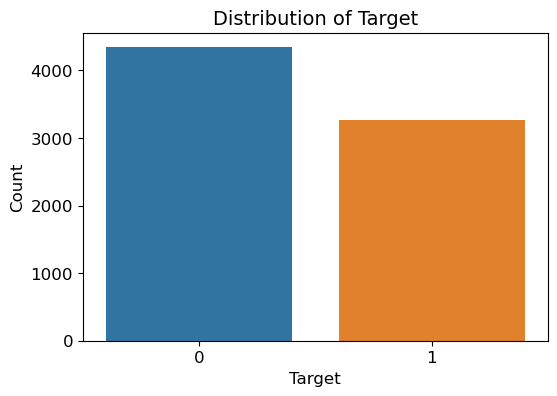

In [9]:
# Bar chart for the 'label' column
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Target', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


So we see the data set is inbalanced with more "not disaster" tweets.

Lets see how the word legnth differs by target.

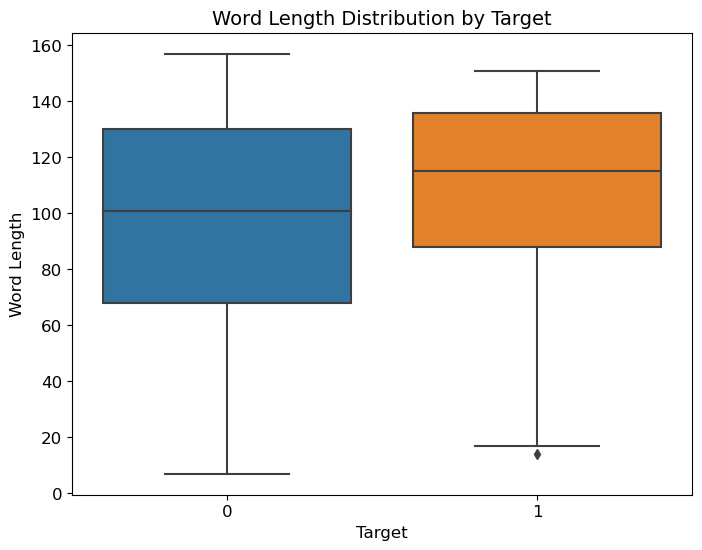

In [10]:
# Calculate the word length for each text in the 'text' column
train['word_length'] = train['text'].apply(len)

# Box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='target', y='word_length', data=train)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Word Length', fontsize=12)
plt.title('Word Length Distribution by Target', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Remove the 'word_length' column from the DataFrame (optional, if not needed later)
train.drop('word_length', axis=1, inplace=True)

They are pretty even with "disaster" tweets having slightly longer length on average and with a slightly smaller range.

Lets see the distributions of the number of words in the tweets by target.

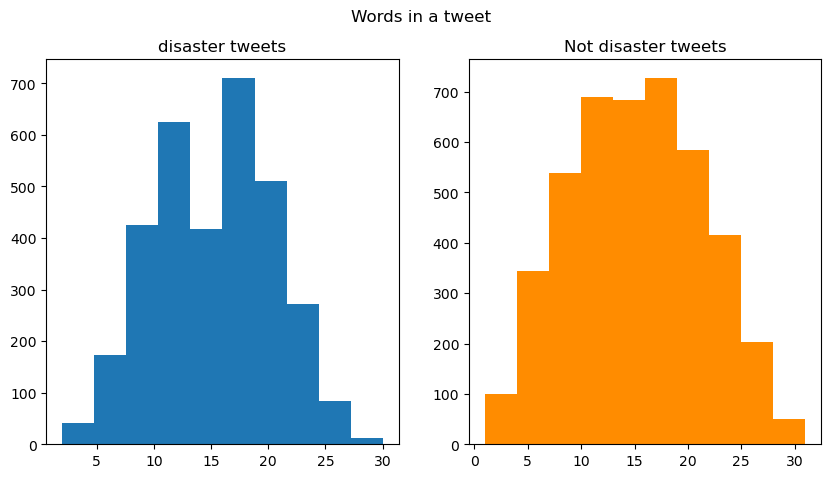

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len)
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len, color='darkorange')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Fairly similar with disaster tweets having more of a bi-modal distribution.

So next we take a look at the target distribution of the keywords.

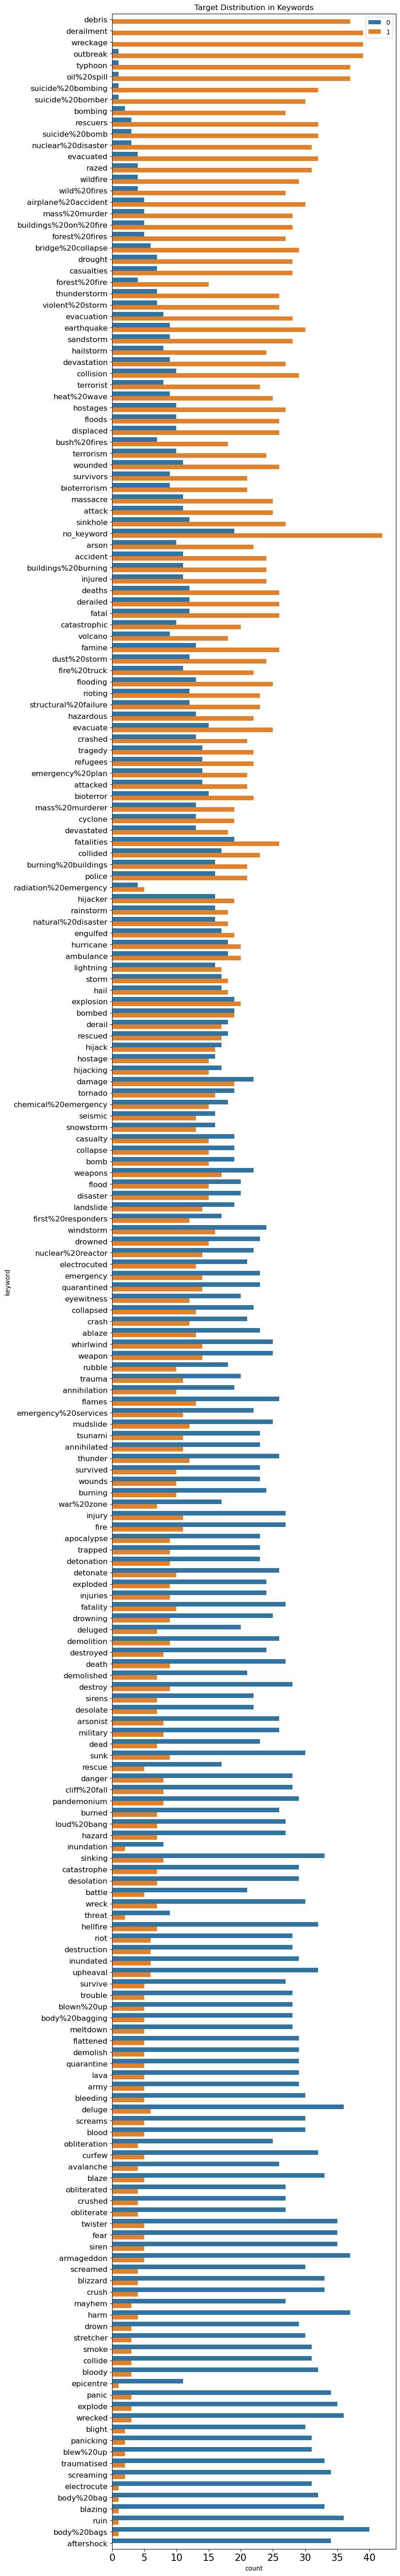

In [12]:
train['target_mean'] = train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train.drop(columns=['target_mean'], inplace=True)

Create a corpus

In [13]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

counter=Counter(create_corpus(0))
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in STOPWORDS) :
        x.append(word)
        y.append(count)

<Axes: >

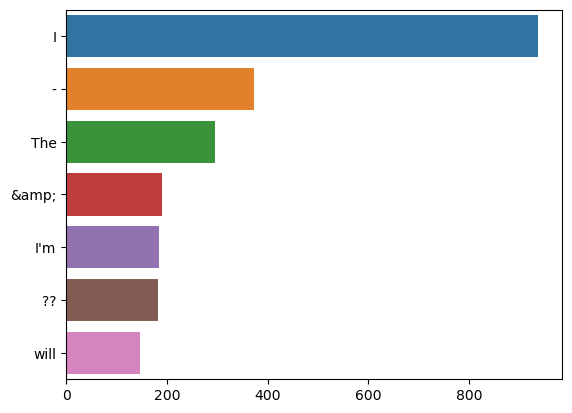

In [14]:
sns.barplot(x=y, y=x)

Now lets clean the text of non-alphanumeric characters, punctuations, stopwords, then tokenize, lemmatize, and join back together.

In [15]:
def clean_text(text):
    # Remove URLs
    cleaned_text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    # Remove non-alphanumeric characters and keep spaces
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', cleaned_text)
    # Remove Twitter handles
    cleaned_text = re.sub(r'@[^\s]+', '', cleaned_text)
    # Remove punctuation
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)
    # Convert to lowercase
    cleaned_text = cleaned_text.lower()
    # Tokenize text
    tokens = word_tokenize(cleaned_text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join the words back into a single string
    cleaned_text = ' '.join(words)
    return cleaned_text

In [16]:
train['cleaned_text'] = train['text'].apply(clean_text)

In [17]:
print(train['cleaned_text'])

0              deed reason earthquake may allah forgive u
1                   forest fire near la ronge sask canada
2       resident asked shelter place notified officer ...
3       13000 people receive wildfire evacuation order...
4       got sent photo ruby alaska smoke wildfire pour...
                              ...                        
7608    two giant crane holding bridge collapse nearby...
7609    ariaahrary thetawniest control wild fire calif...
7610                      m194 0104 utc5km volcano hawaii
7611    police investigating ebike collided car little...
7612    latest home razed northern california wildfire...
Name: cleaned_text, Length: 7613, dtype: object


Now lets generate a WordCloud.

In [19]:
def generate_word_cloud(text_list):
    # Join all the text into a single string
    combined_text = ' '.join(str(val) for val in text_list)

    # Convert all text to lowercase and split into individual words
    words = combined_text.lower().split()

    # Create a set of stopwords
    stopwords = set(STOPWORDS)
    stopwords.add('https')  # Add 'https' to stopwords

    # Generate the WordCloud
    wordcloud = WordCloud(width=5000, height=4000,
                          background_color='black',
                          stopwords=stopwords,
                          min_font_size=10).generate(' '.join(words))

    # Plot the WordCloud image
    plt.figure(figsize=(12, 12), facecolor='k', edgecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)

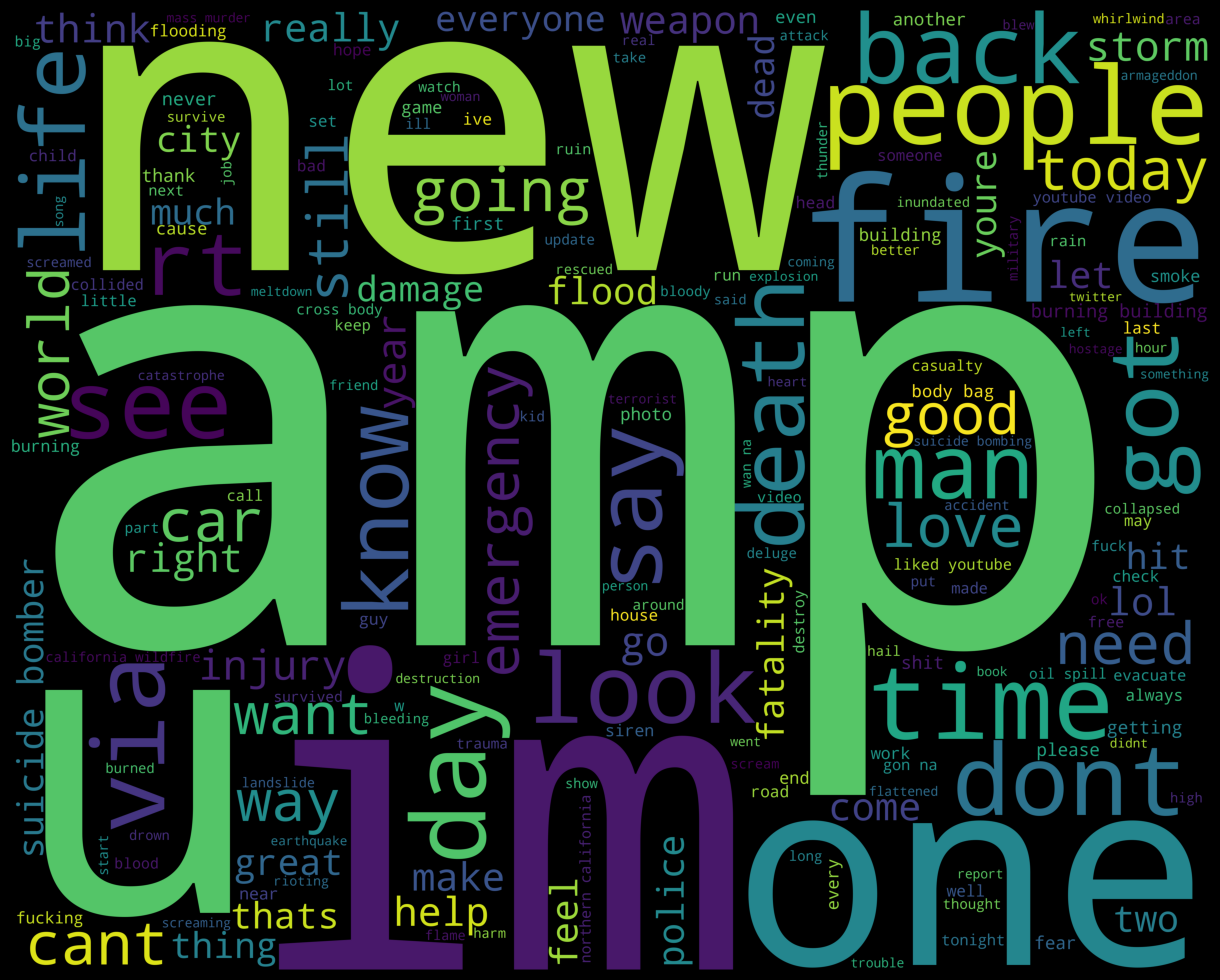

In [20]:
generate_word_cloud(train.cleaned_text.values)

Now we create our target and predictor then split up for modeling.

In [21]:
Y = train['target']
x = train['cleaned_text']

In [22]:
Y.shape, x.shape

((7613,), (7613,))

In [23]:
df_train, df_test, Ytrain, Ytest = train_test_split(x, Y, test_size=0.25)

Now we convert the sentences to sequences.

In [24]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [25]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 13606 unique tokens.


Now we add padding to the sequences.

In [26]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (5709, 25)


In [27]:
data_test = pad_sequences(sequences_test, maxlen = T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1904, 25)


## Modeling

Let's start with a LSTM model that takes sequences as input, processes them through an embedding layer, an LSTM layer, and a couple of dense layers, and finally produces a binary classification output. The model is designed with dropout and regularization techniques to enhance generalization and reduce overfitting.

In [28]:
# Create the model

# We get to choose embedding dimensionality
D = 200

# Hidden state dimensionality
M = 64
# Note: we actually want the size of the embedding to be (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = SpatialDropout1D(0.2)(x) 
x = LSTM(M, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.1))(x)
x = Dense(64, activation='relu')(x)
x = GlobalMaxPooling1D()(x) 
x = Dropout(0.2)(x) 
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [29]:
# Compile and fit

learning_rate = 0.00005
optimizer = Adam(learning_rate=learning_rate)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

print('Training model...')
r = model.fit(
    data_train,
    Ytrain,
    batch_size = 32,
    epochs=50,
    validation_data=(data_test, Ytest)
)

Training model...
Epoch 1/50
179/179 [==============================] - 31s 140ms/step - loss: 20.8405 - accuracy: 0.5463 - val_loss: 18.5266 - val_accuracy: 0.5688
Epoch 2/50
179/179 [==============================] - 24s 133ms/step - loss: 16.5650 - accuracy: 0.5709 - val_loss: 14.7103 - val_accuracy: 0.5688
Epoch 3/50
179/179 [==============================] - 25s 141ms/step - loss: 13.1335 - accuracy: 0.5709 - val_loss: 11.6427 - val_accuracy: 0.5688
Epoch 4/50
179/179 [==============================] - 25s 138ms/step - loss: 10.3760 - accuracy: 0.5709 - val_loss: 9.1793 - val_accuracy: 0.5688
Epoch 5/50
179/179 [==============================] - 25s 141ms/step - loss: 8.1643 - accuracy: 0.5709 - val_loss: 7.2083 - val_accuracy: 0.5688
Epoch 6/50
179/179 [==============================] - 24s 133ms/step - loss: 6.3984 - accuracy: 0.5709 - val_loss: 5.6389 - val_accuracy: 0.5688
Epoch 7/50
179/179 [==============================] - 24s 137ms/step - loss: 4.9934 - accuracy: 0.5709 - 

Epochs 1-5: The model starts with relatively high loss and accuracy values. The accuracy hovers around 57% for both training and validation sets.

Epochs 6-10: There's a gradual decrease in loss, but the accuracy remains stable at around 57% for both training and validation.

Epochs 11-20: The model's performance improves significantly. Loss decreases further, and training accuracy rises to around 86%, while validation accuracy also improves to around 79%.

Epochs 21-30: The model's accuracy continues to improve. Training accuracy reaches about 95%, and validation accuracy stabilizes around 78-79%.

Epochs 31-40: There seems to be some fluctuations in the model's performance, with both training and validation accuracies fluctuating between 76% and 77%.

Epochs 41-50: Towards the end of training, the model's accuracy doesn't show substantial improvement. Training accuracy remains around 97%, while validation accuracy stays around 77-78%.

In summary, the model's training and validation accuracy improved from an initial value of around 57% to a final value of about 78%. This indicates that the model is learning to some extent, but its improvement tapers off after some point. Further fine-tuning or changes to the architecture might be explored to potentially enhance the model's performance.

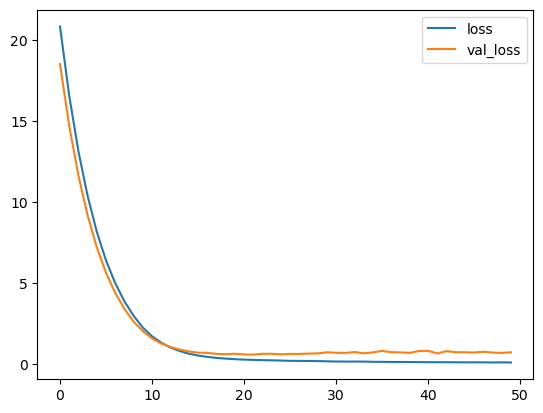

In [30]:
# Plot loss per iteration
plt.plot(r.history['loss'], label ='loss')
plt.plot(r.history['val_loss'], label ='val_loss')
plt.legend()

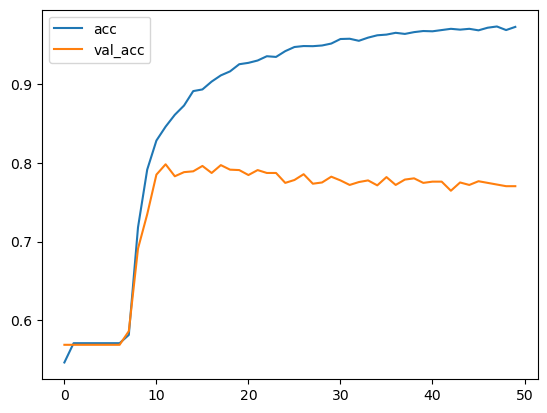

In [31]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label ='acc')
plt.plot(r.history['val_accuracy'], label ='val_acc')
plt.legend()

Let's add a second dense layer and see if it improves

In [32]:
# Create the model

# We get to choose embedding dimensionality
D = 200

# Hidden state dimensionality
M = 64
# Note: we actually want the size of the embedding to be (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = SpatialDropout1D(0.2)(x) 
x = LSTM(M, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.1))(x)
x = Dense(64, activation='relu')(x)
x = GlobalMaxPooling1D()(x) 
x = Dropout(0.2)(x) 
x = Dense(64, activation='relu')(x)
x = GlobalMaxPooling1D()(x) 
x = Dropout(0.2)(x) 
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [33]:
# Compile and fit

learning_rate = 0.00005
optimizer = Adam(learning_rate=learning_rate)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

print('Training model...')
r = model.fit(
    data_train,
    Ytrain,
    batch_size = 64,
    epochs=50,
    validation_data=(data_test, Ytest)
)

Training model...
Epoch 1/50
90/90 [==============================] - 15s 136ms/step - loss: 21.8199 - accuracy: 0.5409 - val_loss: 20.5616 - val_accuracy: 0.5688
Epoch 2/50
90/90 [==============================] - 13s 143ms/step - loss: 19.4402 - accuracy: 0.5709 - val_loss: 18.3185 - val_accuracy: 0.5688
Epoch 3/50
90/90 [==============================] - 12s 136ms/step - loss: 17.3166 - accuracy: 0.5709 - val_loss: 16.3133 - val_accuracy: 0.5688
Epoch 4/50
90/90 [==============================] - 12s 135ms/step - loss: 15.4157 - accuracy: 0.5709 - val_loss: 14.5180 - val_accuracy: 0.5688
Epoch 5/50
90/90 [==============================] - 14s 150ms/step - loss: 13.7141 - accuracy: 0.5709 - val_loss: 12.9093 - val_accuracy: 0.5688
Epoch 6/50
90/90 [==============================] - 12s 137ms/step - loss: 12.1880 - accuracy: 0.5709 - val_loss: 11.4678 - val_accuracy: 0.5688
Epoch 7/50
90/90 [==============================] - 12s 139ms/step - loss: 10.8202 - accuracy: 0.5709 - val_loss

The training accuracy starts at around 54% and gradually increases over the first few epochs.

The training loss starts at a high value and decreases over time as the model learns to make better predictions.

The validation accuracy starts at around 57% and follows a similar pattern to the training accuracy, increasing slightly.

The validation loss also starts high and decreases, reflecting the learning progress of the model.

Both the training and validation accuracy eventually stabilize around the last few epochs, indicating that the model is not overfitting significantly.

The validation accuracy seems to be around 77-78%, and the validation loss is also relatively low, indicating that the model is performing reasonably well on unseen data.

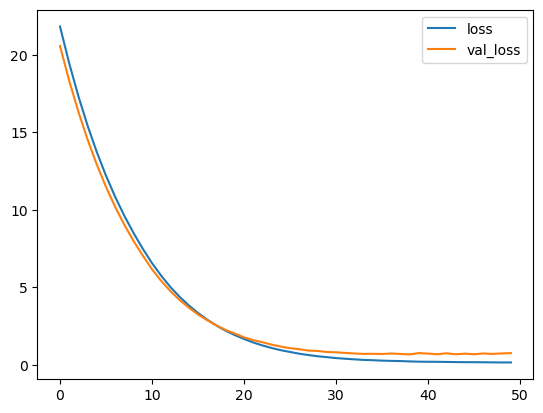

In [34]:
# Plot loss per iteration
plt.plot(r.history['loss'], label ='loss')
plt.plot(r.history['val_loss'], label ='val_loss')
plt.legend()

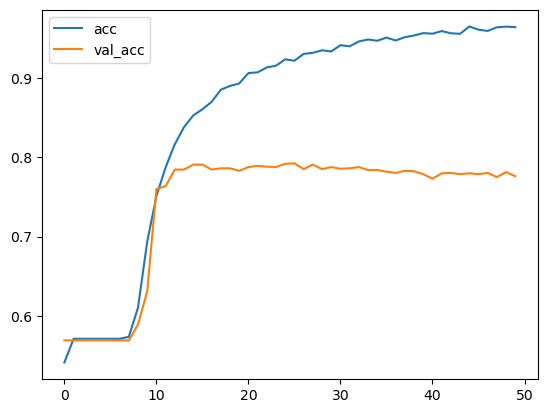

In [35]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label ='acc')
plt.plot(r.history['val_accuracy'], label ='val_acc')
plt.legend()

Lets try a LeakyReLU now and see how that does.

In [36]:
# Create the model

# We get to choose embedding dimensionality
D = 200

# Hidden state dimensionality
M = 64
# Note: we actually want the size of the embedding to be (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = SpatialDropout1D(0.2)(x) 
x = LSTM(M, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.1))(x)
x = Dense(64)(x)
x = LeakyReLU(alpha=0.1)(x) 
x = GlobalMaxPooling1D()(x) 
x = Dropout(0.2)(x) 
x = Dense(1)(x)
x = LeakyReLU(alpha=0.1)(x) 

model = Model(i, x)

In [37]:
# Compile and fit

learning_rate = 0.00005
optimizer = Adam(learning_rate=learning_rate)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

print('Training model...')
r = model.fit(
    data_train,
    Ytrain,
    batch_size = 32,
    epochs=50,
    validation_data=(data_test, Ytest)
)

Training model...
Epoch 1/50
179/179 [==============================] - 28s 140ms/step - loss: 21.1951 - accuracy: 0.5709 - val_loss: 18.8301 - val_accuracy: 0.5688
Epoch 2/50
179/179 [==============================] - 24s 136ms/step - loss: 16.8784 - accuracy: 0.5691 - val_loss: 15.0265 - val_accuracy: 0.5688
Epoch 3/50
179/179 [==============================] - 24s 136ms/step - loss: 13.4615 - accuracy: 0.5647 - val_loss: 11.9594 - val_accuracy: 0.5688
Epoch 4/50
179/179 [==============================] - 25s 138ms/step - loss: 10.6883 - accuracy: 0.5696 - val_loss: 9.4744 - val_accuracy: 0.5688
Epoch 5/50
179/179 [==============================] - 25s 142ms/step - loss: 8.4513 - accuracy: 0.5768 - val_loss: 7.4735 - val_accuracy: 0.5688
Epoch 6/50
179/179 [==============================] - 25s 140ms/step - loss: 6.6505 - accuracy: 0.5779 - val_loss: 5.8710 - val_accuracy: 0.5688
Epoch 7/50
179/179 [==============================] - 24s 132ms/step - loss: 5.2102 - accuracy: 0.5959 - 

The training accuracy starts around 57% and increases gradually over the initial epochs.

The training loss starts high and decreases as the model learns more effective representations.

The validation accuracy starts at around 57% and follows a similar pattern to the training accuracy, increasing slightly.

The validation loss begins at a high value and then decreases as the model improves its performance on unseen data.

Both training and validation accuracy stabilize around the final epochs, suggesting that the model is not overfitting significantly.

The validation accuracy seems to hover around 77-79%, and the validation loss is relatively low, which implies that the model is performing reasonably well on unseen data.

It's worth noting that the validation accuracy doesn't improve significantly over the course of the training, suggesting that the model's learning might have plateaued.

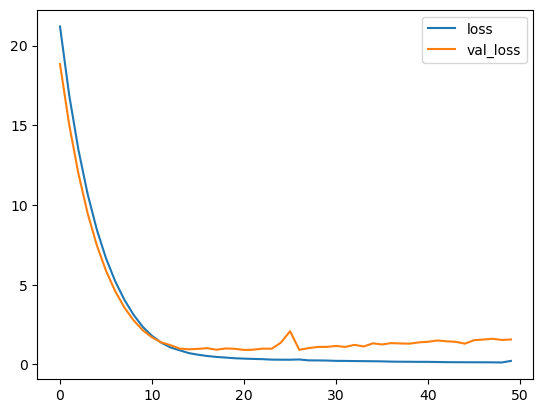

In [38]:
# Plot loss per iteration
plt.plot(r.history['loss'], label ='loss')
plt.plot(r.history['val_loss'], label ='val_loss')
plt.legend()

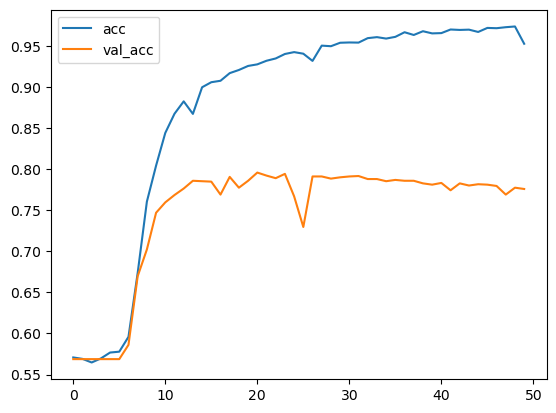

In [39]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label ='acc')
plt.plot(r.history['val_accuracy'], label ='val_acc')
plt.legend()

So all 3 models performed similarly.  Usually best to choose the simplest model in that case so lets choose the first one and tune the hyperparameters.

## Hyperparameter Tuning

In [40]:
def create_model(D, M, learning_rate):
    model = Sequential()
    model.add(Input(shape=(T,)))
    model.add(Embedding(V + 1, D))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(M, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.1)))
    model.add(Dense(64, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    model.fit(
    data_train,
    Ytrain,
    batch_size = 32,
    epochs=20,
    validation_data=(data_test, Ytest)
    )
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)

/tmp/ipykernel_28/1959199444.py:27: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


In [41]:
param_grid = {
    'D': [100, 300],
    'M': [32, 128],
    'learning_rate': [0.00005, 0.0001]
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(data_train, Ytrain)
print("Best parameters: ", grid_result.best_params_)
print("Best score: ", grid_result.best_score_)

Epoch 1/20
179/179 [==============================] - 30s 147ms/step - loss: 11.0921 - accuracy: 0.5544 - val_loss: 10.2399 - val_accuracy: 0.5688
Epoch 2/20
179/179 [==============================] - 26s 145ms/step - loss: 9.4851 - accuracy: 0.5709 - val_loss: 8.7573 - val_accuracy: 0.5688
Epoch 3/20
179/179 [==============================] - 25s 137ms/step - loss: 8.1102 - accuracy: 0.5709 - val_loss: 7.4863 - val_accuracy: 0.5688
Epoch 4/20
179/179 [==============================] - 25s 141ms/step - loss: 6.9299 - accuracy: 0.5709 - val_loss: 6.3945 - val_accuracy: 0.5688
Epoch 5/20
179/179 [==============================] - 25s 140ms/step - loss: 5.9168 - accuracy: 0.5709 - val_loss: 5.4569 - val_accuracy: 0.5688
Epoch 6/20
179/179 [==============================] - 26s 144ms/step - loss: 5.0450 - accuracy: 0.5710 - val_loss: 4.6518 - val_accuracy: 0.5688
Epoch 7/20
179/179 [==============================] - 25s 142ms/step - loss: 4.2964 - accuracy: 0.5710 - val_loss: 3.9599 - val_

So now lets plug the best parameters in and run the model.

In [50]:
# We get to choose embedding dimensionality
D = 300

# Hidden state dimensionality
M = 128

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = SpatialDropout1D(0.2)(x) 
x = LSTM(M, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.1))(x)
x = Dense(64, activation='relu')(x)
x = GlobalMaxPooling1D()(x) 
x = Dropout(0.2)(x) 
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

learning_rate = 0.00001
optimizer = Adam(learning_rate=learning_rate)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

print('Training model...')
r = model.fit(
    data_train,
    Ytrain,
    batch_size = 64,
    epochs=50,
    validation_data=(data_test, Ytest)
)

Training model...
Epoch 1/50
90/90 [==============================] - 15s 134ms/step - loss: 37.8773 - accuracy: 0.5700 - val_loss: 37.2823 - val_accuracy: 0.5688
Epoch 2/50
90/90 [==============================] - 11s 125ms/step - loss: 36.7216 - accuracy: 0.5709 - val_loss: 36.1450 - val_accuracy: 0.5688
Epoch 3/50
90/90 [==============================] - 10s 116ms/step - loss: 35.6009 - accuracy: 0.5709 - val_loss: 35.0417 - val_accuracy: 0.5688
Epoch 4/50
90/90 [==============================] - 11s 127ms/step - loss: 34.5132 - accuracy: 0.5709 - val_loss: 33.9707 - val_accuracy: 0.5688
Epoch 5/50
90/90 [==============================] - 11s 117ms/step - loss: 33.4575 - accuracy: 0.5709 - val_loss: 32.9307 - val_accuracy: 0.5688
Epoch 6/50
90/90 [==============================] - 10s 116ms/step - loss: 32.4324 - accuracy: 0.5709 - val_loss: 31.9204 - val_accuracy: 0.5688
Epoch 7/50
90/90 [==============================] - 12s 132ms/step - loss: 31.4356 - accuracy: 0.5709 - val_loss

We seem to have hit a wall with the LSTMs at ~77% accuracy.  Not bad but maybe there is a better method.

## BERT

BERT (Bidirectional Encoder Representations from Transformers) is a powerful pre-trained natural language processing (NLP) model developed by Google AI's researchers. It's based on the Transformer architecture and has brought significant advancements to various NLP tasks.

Here are some key characteristics and features of BERT:

Bidirectional Context: Unlike previous language models that read text in one direction (either left-to-right or right-to-left), BERT is designed to consider context from both directions. It reads text in a bidirectional manner, which helps it capture the full context of a word based on both its preceding and following words.

Transformer Architecture: BERT is built on the Transformer architecture, which is a neural network architecture designed to handle sequential data like text. Transformers use self-attention mechanisms to weigh the importance of different words in a sentence while encoding it.

Pre-training: BERT is pre-trained on a massive amount of text data from the internet. During pre-training, it learns to predict missing words in sentences (masked language model) and understand sentence relationships (next sentence prediction). This process enables BERT to learn rich contextual representations of words.

Fine-tuning: After pre-training, BERT can be fine-tuned for specific downstream tasks, such as text classification, named entity recognition, question answering, and more. During fine-tuning, BERT's parameters are adjusted to fit the task at hand.

Contextual Word Embeddings: BERT produces contextualized word embeddings, which means that the representation of a word depends on the context it appears in. This helps capture word polysemy (multiple meanings) and improves the representation of rare words.

State-of-the-Art Performance: BERT has achieved state-of-the-art performance on a wide range of NLP benchmarks and tasks. Its contextual understanding of language makes it particularly effective for tasks that require grasping subtle nuances, such as sentiment analysis, paraphrasing, and machine translation.

Open-Source: BERT was released as an open-source project, allowing researchers and developers to use its pre-trained models for various applications.

Variants and Improvements: Since the release of BERT, several improved variants have been developed, including models like GPT (Generative Pre-trained Transformer) and RoBERTa. These models build on the Transformer architecture and address different aspects of language understanding and generation.

In summary, BERT is a breakthrough in NLP due to its ability to capture rich contextual information and its versatility across a wide range of language understanding tasks. Its pre-trained nature and fine-tuning approach have become a standard in modern NLP applications.

Lets load two components of the BERT model for English text.

In [51]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', trainable=True)
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1", trainable=True)

Now we create a function that preprocesses a list of text sequences by tokenizing them, adding special tokens, padding them to a specified length, and generating corresponding attention masks and segment IDs. The resulting outputs can be used as an input to the BERT model

In [52]:
def encode_text_sequences(texts, tokenizer, max_length=512):
    encoded_tokens = []
    attention_masks = []
    segment_ids_list = []
    
    for text in texts:
        tokenized_text = tokenizer.tokenize(text)
            
        tokenized_text = tokenized_text[:max_length-2]
        input_tokens = ["[CLS]"] + tokenized_text + ["[SEP]"]
        padding_length = max_length - len(input_tokens)
        
        encoded_tokens_sequence = tokenizer.convert_tokens_to_ids(input_tokens)
        encoded_tokens_sequence += [0] * padding_length
        attention_mask = [1] * len(input_tokens) + [0] * padding_length
        segment_ids = [0] * max_length
        
        encoded_tokens.append(encoded_tokens_sequence)
        attention_masks.append(attention_mask)
        segment_ids_list.append(segment_ids)
    
    return np.array(encoded_tokens), np.array(attention_masks), np.array(segment_ids_list)

In [53]:
vocab_file = bert_encoder.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_encoder.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [54]:
train_input = encode_text_sequences(train.text.values, tokenizer, max_length=160)
test_input = encode_text_sequences(test.text.values, tokenizer, max_length=160)
train_labels = train.target.values

Next we create the model for BERT and compile.

In [55]:
def build_bert_classification_model(bert_encoder, max_sequence_length=512, dropout_rate = 0.2):
    input_word_ids = Input(shape=(max_sequence_length,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_sequence_length,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_sequence_length,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_encoder([input_word_ids, input_mask, segment_ids])
    pooled_output = sequence_output[:, 0, :]  # Using [CLS] token
    dropout_output = Dropout(rate=dropout_rate)(pooled_output)
    classification_output = Dense(1, activation='sigmoid')(dropout_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=classification_output)
    optimizer = Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [58]:
model_BERT = build_bert_classification_model(bert_encoder, max_sequence_length=160, dropout_rate=0.2)
model_BERT.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 160)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 160)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 160)]        0           []                               
                                                                                                  
 keras_layer_3 (KerasLayer)     [(None, 1024),       335141889   ['input_word_ids[0][0]',         
                                 (None, 160, 1024)]               'input_mask[0][0]',       

In [59]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

train_history = model_BERT.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=2,
    callbacks=[checkpoint], 
    batch_size=8
)

Epoch 1/2
762/762 [==============================] - 465s 564ms/step - loss: 0.4381 - accuracy: 0.8105 - val_loss: 0.3690 - val_accuracy: 0.8444
Epoch 2/2
762/762 [==============================] - 413s 542ms/step - loss: 0.2969 - accuracy: 0.8864 - val_loss: 0.3924 - val_accuracy: 0.8339


BERT will quickly overfit so 2 or 3 epochs is enough.

## Analysis

Next we make our predictions.

In [64]:
#model_BERT.load_weights('model_BERT.h5')
test_pred_BERT = model_BERT.predict(test_input)
test_pred_BERT_int = test_pred_BERT.round().astype('int')

102/102 [==============================] - 63s 596ms/step


In [67]:
# Prediction by BERT model with my tuning for the training data - for the Confusion Matrix
train_pred_BERT = model_BERT.predict(train_input)
train_pred_BERT_int = train_pred_BERT.round().astype('int')

238/238 [==============================] - 141s 595ms/step


In [69]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

Looking at the confusion matrix we see how powerful BERT is.  It has an accuracy of 96.6% predicting the real disaster tweets.

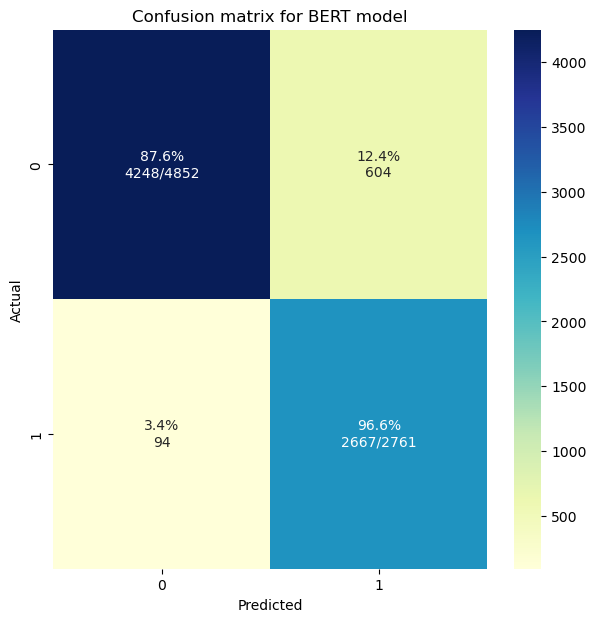

In [70]:
# Showing Confusion Matrix for BERT model
plot_cm(train_pred_BERT_int, train['target'].values, 'Confusion matrix for BERT model', figsize=(7,7))

We can see looking at the histogram that when predicting a 1 the model seems very sure of itself due to there being no tail really.  When predicting a 0 there is more of a tail.

<Axes: ylabel='Frequency'>

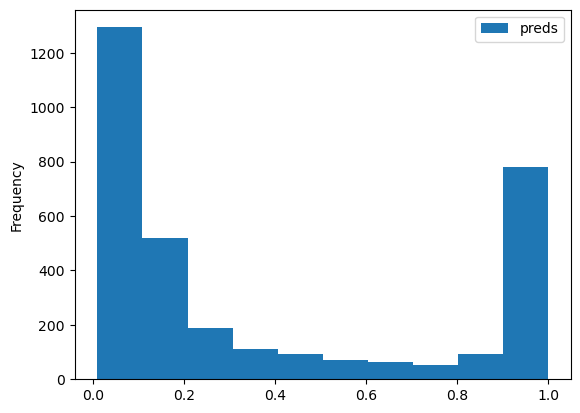

In [71]:
pred = pd.DataFrame(test_pred_BERT, columns=['preds'])
pred.plot.hist()

## Conclusion

When creating the LSTM models I seem to have really hit a wall at about ~77% accuracy.  I created many more models that what I included in this notebook to try to achieve a higher accuracy but couldn't get any improvement.  Possibly adding some CNN layers could help.  I leveraged the pre-trained BERT to achieve a better model.

## Submission

In [74]:
submission['target'] = test_pred_BERT_int
submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [76]:
submission.to_csv("submission.csv", index=False)

In [77]:
!echo "qid,prediction" > submission.csv

In [78]:
from IPython.display import FileLink
FileLink('submission.csv')

/kaggle/working/submission.csv